In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.pipeline import make_pipeline

import os

import skimage
import skimage.color
import skimage.transform
import skimage.io
import skimage.feature

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
class rgb2gray_transform(BaseEstimator,TransformerMixin):
    import skimage.color
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        return np.array([skimage.color.rgb2gray(x) for x in X])

In [4]:
class hogtransformer(BaseEstimator,TransformerMixin):
    import skimage.feature
    def __init__(self,orientations=9,pixels_per_cell=(8,8),cells_per_block=(3, 3)):
        self.orientations=orientations
        self.pixels_per_cell=pixels_per_cell
        self.cells_per_block=cells_per_block
    
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        def local_hog(img):
            hog_features= skimage.feature.hog(img,
                               orientations=self.orientations,
                               pixels_per_cell=self.pixels_per_cell,
                               cells_per_block=self.cells_per_block)
            return hog_features
        
        features = np.array([local_hog(x) for x in X])
#         hog_images= np.array([local_hog(x) for x in X])
        return features

## Pipeline Model

In [7]:
# read the image
image = skimage.io.imread('eagle.jpg')
# transfrom image into 80x80
image_resized = skimage.transform.resize(image,(80,80))
# rescale
rescaled_image = 255*image_resized

image_transformed = rescaled_image.astype(np.uint8) # converting to 8 bit integer

# rgb2gray 
gray = skimage.color.rgb2gray(image_transformed) # can use custom function as well
# graify = rgb2gray_transform()
# gray = graify.fit_transform(image_transformed)

# hog feature (choosing best hyperparameter)

hog_feature_vector = skimage.feature.hog(gray,
                                  orientations=10, pixels_per_cell=(8,8),cells_per_block=(3,3))

# hog = hogtransformer(orientations=8, pixels_per_cell=(8,8),cells_per_block=(3,3))
# hog_feature_vector = hog.fit_transform(gray)



In [8]:
hog_feature_vector.reshape(1,-1)

array([[0.01633377, 0.00198746, 0.03191212, ..., 0.02345522, 0.01844644,
        0.00353701]])

In [9]:
#  rescaled_image  # float value messed all our image
image_transformed

array([[[ 4, 17,  0],
        [ 5, 18,  0],
        [ 6, 19,  1],
        ...,
        [ 7, 18,  1],
        [ 6, 17,  0],
        [ 6, 16,  0]],

       [[ 6, 20,  0],
        [ 6, 20,  0],
        [ 7, 22,  0],
        ...,
        [ 7, 18,  1],
        [ 7, 16,  0],
        [ 6, 15,  0]],

       [[ 7, 22,  0],
        [ 8, 23,  0],
        [ 8, 24,  0],
        ...,
        [ 7, 17,  0],
        [ 7, 15,  0],
        [ 6, 14,  0]],

       ...,

       [[ 0,  7,  0],
        [ 0,  6,  0],
        [ 0,  6,  0],
        ...,
        [ 4,  6,  1],
        [ 7,  8,  3],
        [10,  9,  4]],

       [[ 0,  7,  0],
        [ 0,  6,  0],
        [ 0,  6,  0],
        ...,
        [ 3,  5,  0],
        [ 5,  6,  1],
        [ 8,  9,  4]],

       [[ 0,  7,  0],
        [ 0,  7,  0],
        [ 0,  7,  0],
        ...,
        [ 4,  6,  1],
        [ 4,  5,  0],
        [ 7,  7,  3]]], dtype=uint8)

In [13]:
scaler = pickle.load(open('../Model/dsa_scaler.pickle','rb'))
model = pickle.load(open('../Model/image_classification_sgd.pickle','rb'))

In [14]:
model.get_params()

{'alpha': 0.01,
 'average': False,
 'class_weight': None,
 'early_stopping': True,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [15]:
scaled = scaler.transform(hog_feature_vector.reshape(1,-1))
y_pred = model.predict(scaled)

In [16]:
y_pred

array(['eagle'], dtype='<U8')

### Calculating the Probability

In [17]:
# decision calculates the confidence socre for each class

decision_value = model.decision_function(scaled)
# decision_value = np.abs(decision_value)
decision_value_scaled = decision_value/1e+12

In [18]:
decision_value_scaled

array([[-160.35833104, -280.08289736, -137.56631757, -165.80567476,
        -269.32375694, -239.43744718,  -58.12548143,   46.27342712,
        -286.60690957, -157.00255078, -232.46465819, -144.10691717,
        -292.23695395, -223.66607129,  -82.28977164, -111.70178246,
        -180.42241213, -157.85148441, -146.07941565, -329.18516949]])

In [19]:
labels = model.classes_
labels

array(['bear', 'cat', 'chicken', 'cow', 'deer', 'dog', 'duck', 'eagle',
       'elephant', 'human', 'lion', 'monkey', 'mouse', 'natural', 'panda',
       'pigeon', 'rabbit', 'sheep', 'tiger', 'wolf'], dtype='<U8')

In [20]:
decision_value=decision_value.flatten()

(array([-3.5e+14, -3.0e+14, -2.5e+14, -2.0e+14, -1.5e+14, -1.0e+14,
        -5.0e+13,  0.0e+00,  5.0e+13,  1.0e+14]),
 <a list of 10 Text major ticklabel objects>)

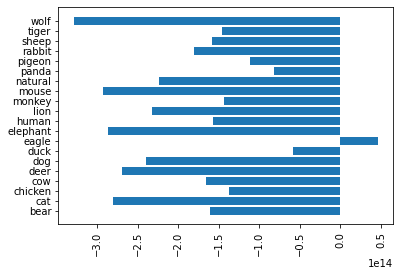

In [21]:
plt.barh(labels,decision_value,)
plt.xticks(rotation=90)

In [22]:
## calculate z-score

z = scipy.stats.zscore(decision_value)
z

array([ 2.25143322e-01, -1.11967772e+00,  4.81157441e-01,  1.63955358e-01,
       -9.98824344e-01, -6.63122661e-01,  1.37348649e+00,  2.54616018e+00,
       -1.19295950e+00,  2.62837540e-01, -5.84799944e-01,  4.07689344e-01,
       -1.25619967e+00, -4.85968725e-01,  1.10205810e+00,  7.71684041e-01,
       -2.28958325e-04,  2.53301788e-01,  3.85533011e-01, -1.67122509e+00])

In [23]:
prob = scipy.special.softmax(z)
prob

array([0.03513309, 0.0091552 , 0.04538391, 0.03304782, 0.01033128,
       0.01445265, 0.1107734 , 0.35786662, 0.00850829, 0.03648268,
       0.01563013, 0.04216918, 0.00798688, 0.01725378, 0.08444144,
       0.06068425, 0.0280439 , 0.03613645, 0.04124514, 0.00527393])

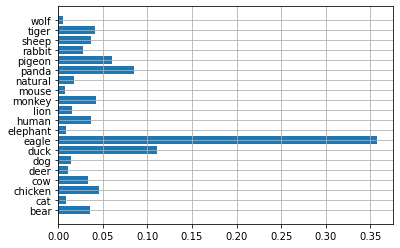

In [24]:
plt.barh(labels,prob)
plt.grid()

## top-5 prob values

In [26]:
top_5_prob_index = prob.argsort()[::-1][:5]
top_5_prob_index

array([ 7,  6, 14, 15,  2])

In [27]:
top_labels = labels[top_5_prob_index]

In [28]:
top_5_prob_values = prob[top_5_prob_index]

In [29]:
top_5_prob_values

array([0.35786662, 0.1107734 , 0.08444144, 0.06068425, 0.04538391])

In [30]:
top_dict = dict()
for key,value in zip(top_labels,top_5_prob_values):
    top_dict[key]=np.round(value,2)

In [31]:
top_dict

{'eagle': 0.36, 'duck': 0.11, 'panda': 0.08, 'pigeon': 0.06, 'chicken': 0.05}

## making pipeline function

In [33]:
def pipe_fun(path,scaler_transformed,model_sgd):
    # read the image
    image = skimage.io.imread(path)
    # making transformation
    image_resized = skimage.transform.resize(image,(80,80))
    # rescaling
    rescaled_image = 255*image_resized
    image_transformed = rescaled_image.astype(np.uint8) # converting to 8 bit integer
    # graify
    gray = skimage.color.rgb2gray(image_transformed) # can use custom function as well
    # hog feature extraction
    hog_feature_vector = skimage.feature.hog(gray,
                                  orientations=10, pixels_per_cell=(8,8),cells_per_block=(3,3))
    
    #scaling
    scaled = scaler_transformed.transform(hog_feature_vector.reshape(1,-1))
    y_pred = model_sgd.predict(scaled)
    # confidence score for each class
    decision_value = model_sgd.decision_function(scaled)
    decision_value=decision_value.flatten()
    labels = model_sgd.classes_
    # probabilty 
    z = scipy.stats.zscore(decision_value)
    prob = scipy.special.softmax(z)
    top_5_prob_index = prob.argsort()[::-1][:5]
    top_5_prob_values = prob[top_5_prob_index]
    top_labels = labels[top_5_prob_index]
    #making dictionary
    top_dict = dict()
    for key,value in zip(top_labels,top_5_prob_values):
        top_dict[key]=np.round(value,2)
    
    return top_dict

In [34]:
pipe_fun('eagle.jpg',scaler,model)

{'eagle': 0.36, 'duck': 0.11, 'panda': 0.08, 'pigeon': 0.06, 'chicken': 0.05}